## day 07: Dealing with texts using CNN

Today we're gonna apply the newly learned tools for the task of predicting job salary.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### About the challenge

[Competition page](https://www.kaggle.com/c/job-salary-prediction/data) stays that we need to predict salary based on Title, Descriptiton and some categorical features.

Let's download the data\
(you could do it manually [from here](https://gin.g-node.org/v-goncharenko/ml-mipt/src/master/data) or [here](https://yadi.sk/d/vVEOWPFY3NruT7) or [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz) or from competition directly).

In [2]:
!wget -nc https://gin.g-node.org/v-goncharenko/ml-mipt/raw/476d7064d45ab80d98cdc4c42a4c4167b068c420/data/Train_rev1.csv.zip
!unzip -u Train_rev1.csv.zip

File ‘Train_rev1.csv.zip’ already there; not retrieving.

Archive:  Train_rev1.csv.zip


In [3]:
data = pd.read_csv("Train_rev1.csv")
data.shape

(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

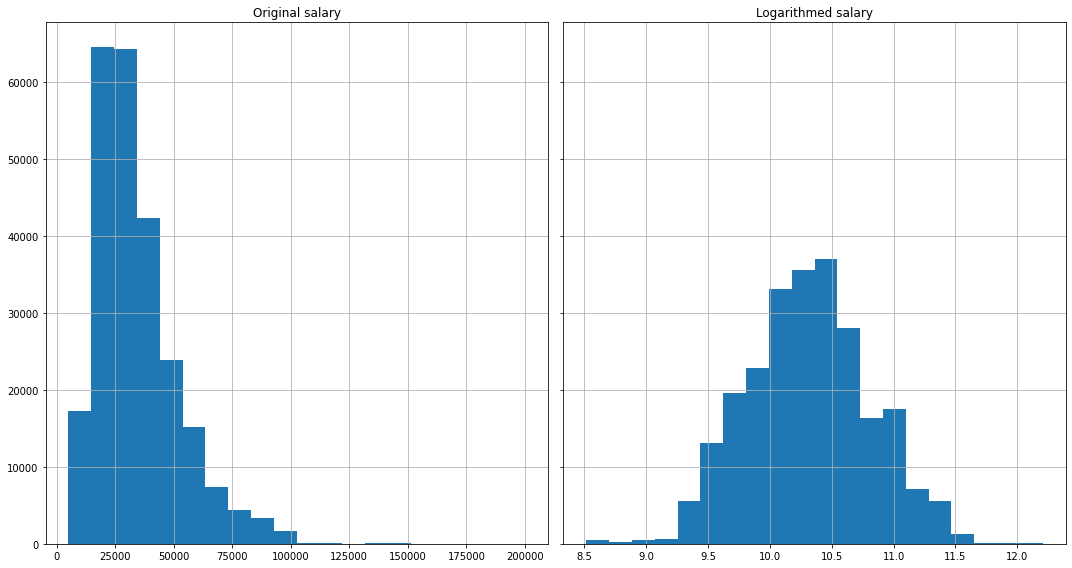

In [5]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"])

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 8), tight_layout=True)

axes[0].hist(data["SalaryNormalized"], bins=20)
axes[0].set_title("Original salary")
axes[0].grid()

axes[1].hist(data["Log1pSalary"], bins=20)
axes[1].set_title("Logarithmed salary")
axes[1].grid()

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

# cast missing values to string "Unknown"
data[categorical_columns] = data[categorical_columns].fillna("Unknown")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
220845,72373830,"Senior Network Engineer, Cisco, Linux, ****K","Senior Network Engineer, Cisco, Linux, ****K**...",Oxfordshire Oxford OX1 1,Coscote,full_time,permanent,Monarch Recruitment,IT Jobs,50000.00 - 60000.00 GBP Annual,55000,jobg8.com,10.915107
126110,69994990,TRAINEE MORTGAGE BROKERS,Trainee Mortgage Brokers Location: Hammersmith...,London South East,South East London,Unknown,permanent,Premier Jobs UK Limited,Accounting & Finance Jobs,"Unspecified ote 50,000+",50000,totaljobs.com,10.819798
163098,71213566,Sales Executive Inbound Leads,"A leading Office Broker company, based in Stan...",Harrow,Harrow,full_time,Unknown,Recruitment Genius,Sales Jobs,25000,25000,careerbuilder.com,10.126671


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [7]:
# Raw data
data["FullDescription"][2::100000]

2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object

In [8]:
import nltk


tokenizer = nltk.tokenize.WordPunctTokenizer()


def normalize(text):
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    return " ".join(tokens)


data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [9]:
# Tokenized data
print(data["FullDescription"][2::100000])

2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter

Count how many times does each token occur in both "Title" and "FullDescription" in total\
build a dictionary { token -> it's count }

In [11]:
%%time
token_counts = Counter()

for _, row in data[text_columns].iterrows():
    for text in row:
        token_counts.update(text.split(" "))

CPU times: user 22.7 s, sys: 13.1 ms, total: 22.7 s
Wall time: 22.7 s


In [12]:
%%time
token_counts2 = Counter()

for row in data[text_columns].values.flatten():
    token_counts2.update(row.split())

CPU times: user 7.66 s, sys: 19.4 ms, total: 7.68 s
Wall time: 7.68 s


In [13]:
token_counts == token_counts2

True

**Note:** `pandas` is extra slow compared to numpy (23 vs 8 seconds) - use with caution

In [14]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


We plot only first less frequent 10000!!! (which is much less than all words count ~ 200k)


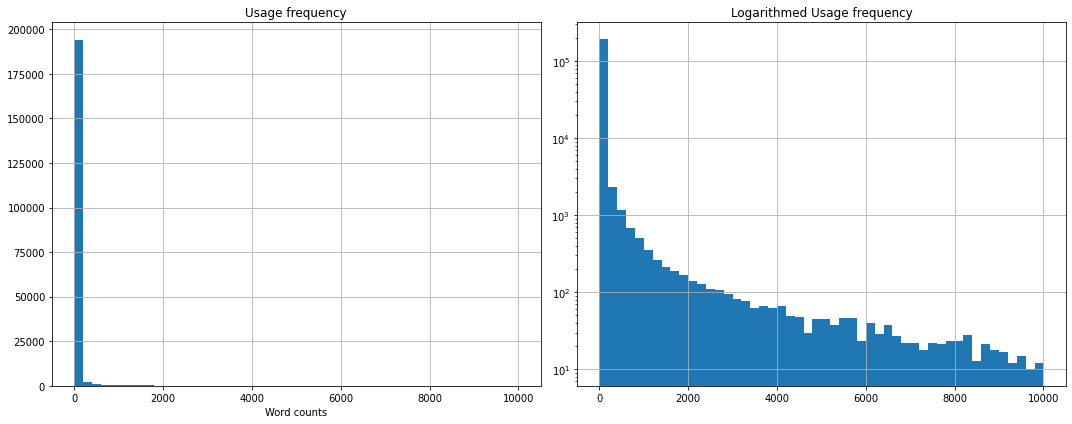

In [15]:
print("We plot only first less frequent 10000!!! (which is much less than all words count ~ 200k)")

token_counts_list = list(token_counts.values())

fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)

axes[0].hist(token_counts_list, range=[0, 10 ** 4], bins=50)
axes[0].set_title("Usage frequency")
axes[0].set_xlabel("Word counts")
axes[0].grid()

axes[1].hist(token_counts_list, range=[0, 10 ** 4], bins=50, log=True)
axes[1].set_title("Logarithmed Usage frequency")
axes[0].set_xlabel("Word counts")
axes[1].grid()

plt.show()

Now filter tokens a list of all tokens that occur at least 10 times.

In [16]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, counts in token_counts.items() if counts >= min_count]

In [17]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 34158


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [18]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [19]:
from typing import Optional

In [20]:
UNK_IX, PAD_IX = token_to_id[UNK], token_to_id[PAD]


def as_matrix(sequences, max_len: Optional[int] = None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    if max_len is None:
        max_len = max(map(len, sequences))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))

    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix

In [21]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")

print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [22]:
from sklearn.feature_extraction import DictVectorizer


# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [23]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [24]:
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def make_batch(data, max_len: Optional[int] = None, word_dropout: float = 0.0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

In [25]:
batch = make_batch(data_train[:3], max_len=10)
batch

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1,     1,     1,
             1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051,     1,     1,
             1],
        [10609, 30412, 17746,    33,  8705, 29157,    65,     1,     1,
             1]], dtype=int32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71153981, 10.46313191, 10.71443999])}

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [26]:
import torch
from torch import nn

In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [27]:
# You will need these to make it simple


class Reorder(nn.Module):
    """Reorders dimensions so"""

    def forward(self, input):
        return input.permute((0, 2, 1))

To generate minibatches we will use simple pyton generator.

In [28]:
def iterate_batches(
    data, batch_size: int = 256, shuffle: bool = True, cycle: bool = False, **kwargs
):
    """Iterates batches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [29]:
iterator = iterate_batches(data_train, 3)
batch, target = next(iterator)

In [30]:
# Here is some startup code:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64
n_maximums = 2

In [39]:
class TextCnnModel(nn.Sequential):
    def __init__(self, n_tokens: int, hid_size: int, n_maximums: int, out_dim: int):
        super().__init__(
            nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size),
            Reorder(),
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size * 2, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=hid_size * 2,
                out_channels=hid_size * 2,
                kernel_size=3,
            ),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(n_maximums),
            nn.Flatten(),
            nn.Linear(hid_size * 2 * n_maximums, out_dim),
        )

In [40]:
simple_model = TextCnnModel(n_tokens, hid_size, n_maximums, 1)

__Remember!__ We are working with regression problem and predicting only one number.

In [41]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
input_tensor = torch.tensor(batch["FullDescription"], dtype=torch.long)
out = simple_model(input_tensor)
out.shape

torch.Size([3, 1])

In [42]:
out.view(3, -1).shape

torch.Size([3, 1])

In [49]:
# without the reorder operation
# batch_size, seq_len, n_features
# equal to
# N, L, C_{\text{in}}
# and we want
# (N, C_{\text{in}}, L)
out.shape

torch.Size([3, 1])

In [51]:
simple_model.to(device)

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (adaptive_pool): AdaptiveMaxPool1d(output_size=2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

And now simple training pipeline:

In [ ]:
from IPython.display import clear_output

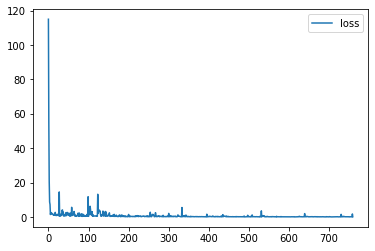

In [53]:
epochs = 1

model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_batches(data_train)):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)

        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target)  # <YOUR CODE HERE>

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.item())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

In [54]:
simple_model.eval()

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (conv1): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (adaptive_pool): AdaptiveMaxPool1d(output_size=2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

Let's check the model quality.

In [55]:
batch_size = 256

In [56]:
from tqdm import tqdm_notebook


def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm_notebook(
        iterate_batches(data, batch_size=batch_size, shuffle=False, **kw)
    ):
        batch = torch.tensor(batch_x["FullDescription"], dtype=torch.long).to(device)
        batch_pred = simple_model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error


print_metrics(simple_model, data_train, name="Train")
print_metrics(simple_model, data_val, name="Val");

<ipython-input-56-c500e77a6287>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_notebook(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):


0it [00:00, ?it/s]

Train results:
Mean square error: 0.21958
Mean absolute error: 0.35360


0it [00:00, ?it/s]

Val results:
Mean square error: 0.22176
Mean absolute error: 0.35481


### Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [69]:
from torchsummary import summary

In [ ]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()
        self.title_net = nn.Sequential(  # bs, len
            nn.Embedding(n_tokens, embedding_dim=hid_size),  # bs, len, hid_size
            nn.LSTM(),  # bs, short_mem_size (5)
        )

        self.descr_net = TextCnnModel(n_tokens, hid_size, n_maximums, 15)  # bs, cnn_size (15)

        self.category_net = nn.Linear(5, 2)  # bs, 2

        self.fc = nn.Linear(22, 1)

    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title = self.title_net(input1)

        full = self.descr_net(input2)

        category = self.category_net(input3)

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                full.view(full.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        return self.fc(concatenated)

In [ ]:
# Another implementation


class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]


class ThreeInputsNet2(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, embedding_dim=hid_size)

        # self.title_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        # <YOUR CODE HERE>  title part of network
        self.title_encoder = nn.Sequential(
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=2),
            nn.ReLU(),
            GlobalMaxPooling(),  # nn.AdaptiveMaxPool1d(hid_size),
            nn.Linear(hid_size, hid_size),
        )

        # self.full_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        # <YOUR CODE HERE>  description part of network
        self.desc_encoder = nn.Sequential(
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=3),
            nn.ReLU(),
            GlobalMaxPooling(),  # nn.AdaptiveMaxPool1d(hid_size),
            nn.Linear(hid_size, hid_size),
        )

        self.category_out = nn.Sequential(
            nn.Linear(3768, hid_size * 8),
            nn.ReLU(inplace=True),
            nn.Linear(hid_size * 8, hid_size * 2),
            nn.ReLU(inplace=True),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(inplace=True),
        )

        self.predictor = nn.Sequential(
            nn.Linear(hid_size * 3, hid_size), nn.ReLU(), nn.Linear(hid_size, 1)
        )

    def forward(self, whole_input):
        input1 = whole_input["Title"]
        input2 = whole_input["FullDescription"]
        input3 = whole_input["Categorical"]

        title_beg = self.embedder(input1).permute((0, 2, 1))
        title = self.title_encoder(title_beg)  # <YOUR CODE HERE>

        full_beg = self.embedder(input2).permute((0, 2, 1))
        full = self.desc_encoder(full_beg)  # <YOUR CODE HERE>

        category = self.category_out(input3)  # <YOUR CODE HERE>

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                full.view(full.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        out = self.predictor(concatenated)  # <YOUR CODE HERE>

        return out

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# <YOUR CODE HERE>

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# <YOUR CODE HERE>

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

## References

Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). \
_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._